## Import

In [1]:
#%matplotlib notebook
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
#%matplotlib notebook
import copy

## Master science image

In [2]:
fits_dir = "/data/tnorecon/RECON_clean/gardnerville/"
fits_data = fits.getdata(fits_dir + "20201222/20201222_01/00001.fits")

In [3]:
fits.getheader(fits_dir + "20201222/20201222_01/00001.fits")

SIMPLE  =                    T / Written by IDL:  Thu Jan 14 12:06:51 2021      
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                  720 /                                                
NAXIS2  =                  480 /                                                
DATE    = '2021-01-14'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
EXPTIME =             0.533800 /Exposure time in seconds                        
DATE-OBS= '2020-12-22T04:53:35.107' /Start of exposure UTC                      

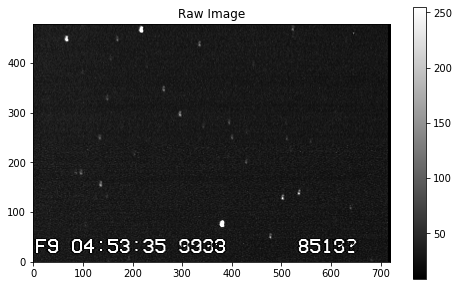

In [24]:
plt.figure(figsize=(8,5))
plt.imshow(fits_data, cmap='gray', origin="top")
plt.title("Raw Image")
plt.colorbar();

## Dark Frame

In [5]:
fits_dark = fits.getdata(fits_dir + "20201222/20201222_03.dark")
fits_minusdark = fits_data - fits_dark

In [6]:
"""# Change nan values to zero
def changenantozero(fitsfile):
    findnans = np.isnan(fitsfile)
    fitsfile[findnans] = 0
    return fitsfile[findnans]"""

'# Change nan values to zero\ndef changenantozero(fitsfile):\n    findnans = np.isnan(fitsfile)\n    fitsfile[findnans] = 0\n    return fitsfile[findnans]'

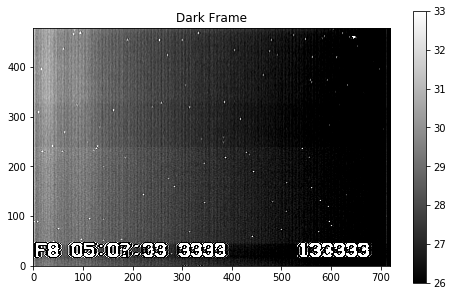

In [7]:
plt.figure(figsize=(8,5))
plt.imshow(fits_dark, cmap='gray', origin="top", vmin=26, vmax=33)
plt.title("Dark Frame")
plt.colorbar();

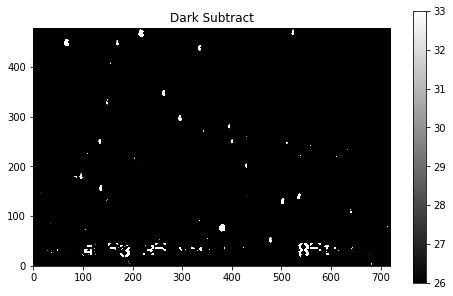

In [8]:
plt.figure(figsize=(8,5))
plt.imshow(fits_minusdark, cmap='gray', origin="top", vmin=26, vmax=33)
plt.title("Dark Subtract")
plt.colorbar();

## Flat field

In [9]:
#fits_flatfield = fits.getdata(fits_dir + "20201222/20201222_03.flat")
fits_flatfield = fits_minusdark

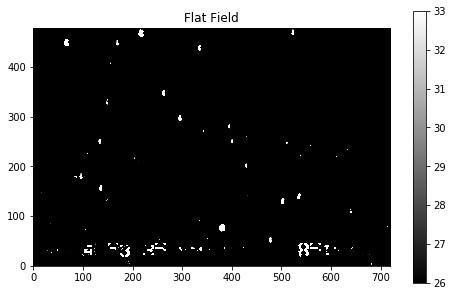

In [10]:
plt.figure(figsize=(8,5))
plt.imshow(fits_flatfield, cmap='gray', origin="top", vmin=26, vmax=33)
plt.title("Flat Field")
plt.colorbar();

## Normalize Flat Field

In [11]:
# Find median value
flatfield_median = np.median(fits_flatfield)
print(flatfield_median)

# Divide median
flatfield_normalized = fits_flatfield/flatfield_median

# Divide science image by normalized flat frame
fits_normalized = fits_minusdark/flatfield_normalized

5.3097525


/home/jhub/.conda/envs/hubenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/jhub/.conda/envs/hubenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


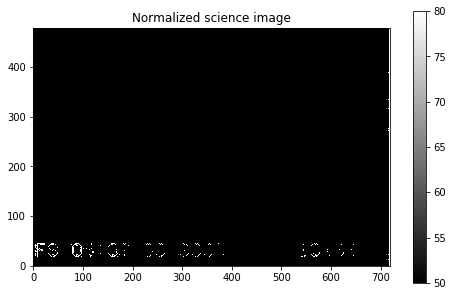

In [27]:
plt.figure(figsize=(8,5))
plt.imshow(fits_normalized, cmap='gray', origin="top", vmin=50, vmax=80)
plt.title("Normalized science image")
#plt.xlim(220,240)
#plt.ylim(190,220)
plt.colorbar();

## Circular mask

In [13]:
def circle_mask(fitsfile, height, width, center, radius):
    
    # 2D array to x,y coordinates
    y, x = np.ogrid[:height, :width]
    
    # define center
    c_x, c_y = center
    
    # calculate distance from center using the equation for a circle
    dists_sqrd = (x - c_x)**2 + (y - c_y)**2
    
    # create a mask
    mask = dists_sqrd > radius**2
    
    # change data
    fits_masked = copy.deepcopy(fitsfile)
    # Turn all values in the fits image that's included in the mask, zero. 
    # Note: the mask is everything outside the circle
    fits_masked[mask] = 0
    
    return fits_masked

In [14]:
# Define the location of the star
star_center = [280,240]

# Define size of the image
height,width = np.shape(fits_normalized)

# Define radius
star_radius = 10

# Masked image
fits_masked = circle_mask(fits_normalized, height, width, star_center, star_radius)

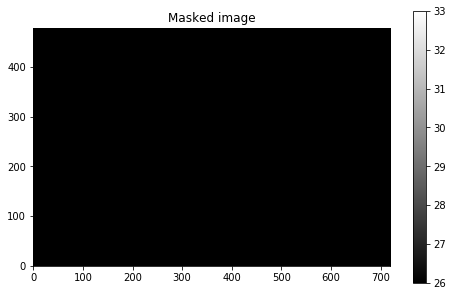

In [15]:
plt.figure(figsize=(8,5))
plt.imshow(fits_masked, cmap='gray', origin="top", vmin=26, vmax=33)
plt.title("Masked image")
plt.colorbar();

## Where is the star?

In [16]:
maxvalue = np.where(fits_masked == np.amax(fits_masked))
print(maxvalue[1][0])

274


## Donut

In [17]:
# Sum of aperture values
aperture_sum = np.sum(fits_masked)
print(aperture_sum)

# Aperture area
aperture_area = np.count_nonzero(fits_masked)
print(aperture_area)

1683.1915
317


In [18]:
# Calculating donut shape array
outer_annulus = circle_mask(fits_normalized, height, width, star_center, 40)
inner_annulus = circle_mask(fits_normalized, height, width, star_center, 20)

annulus = outer_annulus - inner_annulus

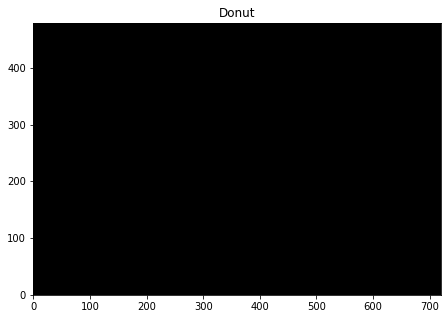

In [19]:
# Plot 
plt.figure(figsize=(8,5))
plt.imshow(annulus, cmap='gray', origin="top", vmin=26, vmax=33)
plt.title("Donut")
#plt.xlim(200,360)
#plt.ylim(200,280)
plt.show()

In [20]:
# Count donut
annulus_sum = np.sum(annulus)
annulus_area = np.count_nonzero(annulus)
avg_bg_count_per_pixel = annulus_sum/annulus_area
print(avg_bg_count_per_pixel)

5.309752770037155


## Count the stars

In [21]:
#Star counts = Aperture counts - (Average Background * Aperture Area)
star_count = aperture_sum - (avg_bg_count_per_pixel * aperture_area)
print(star_count)

-9.978146567846125e-05


## Flux and uncertainty

In [22]:
def measureflux(start,finish,star_center,star_radius=10,outannulus_radius=40,inannulus_radius=20):
    
    # Define directory
    fits_dir = "/data/tnorecon/RECON_clean/laughlin/"
    
    # Define dark image
    fits_dark = fits.getdata(fits_dir + "20201021/20201021_4.dark")
    
    # Define flatfield
    fits_flatfield = fits.getdata(fits_dir + "20201021/20201021_3.flat")
    
    # Define time
    time = np.arange(start,finish+1,1)
    
    # Create a list of fits file names
    filelist = np.arange(start,finish+1,1)
    
    ############
    ### FLUX ###
    ############
    
    fluxovertime = []
    uncertainty = []
    
    # Loop through the files
    for f in filelist:
        fits_data = fits.getdata(fits_dir + "20201021/20201021_2/00{}.fits".format(f))
        fits_minusdark = fits_data - fits_dark

        # Find median value
        flatfield_median = np.median(fits_flatfield)

        # Divide median
        flatfield_normalized = fits_flatfield/flatfield_median

        # Divide science image by normalized flat frame
        fits_normalized = fits_minusdark/flatfield_normalized
    
        # Define size of the image
        height,width = np.shape(fits_normalized)

        # Masked image
        fits_masked = circle_mask(fits_normalized, height, width, star_center, star_radius)
        
        # Define actual location of the star
        maxvalue = np.where(fits_masked == np.amax(fits_masked))
        star_center = [maxvalue[1][0],maxvalue[0][0]]
        #print(star_center)
        
        # Redefine masked image
        fits_masked = circle_mask(fits_normalized, height, width, star_center, star_radius)

        # Sum of aperture values
        aperture_sum = np.sum(fits_masked)

        # Aperture area
        aperture_area = np.count_nonzero(fits_masked)

        # Calculating donut shape array
        outer_annulus = circle_mask(fits_normalized, height, width, star_center, outannulus_radius)
        inner_annulus = circle_mask(fits_normalized, height, width, star_center, inannulus_radius)

        annulus = outer_annulus - inner_annulus
        
        # Plot 
        #plt.figure(figsize=(8,5))
        #plt.imshow(annulus+fits_masked, cmap='gray', origin="top", vmin=26, vmax=33)
        #plt.title("Donut")
        #plt.show()

        # Count donut
        annulus_sum = np.sum(annulus)
        annulus_area = np.count_nonzero(annulus)
        avg_bg_count_per_pixel = annulus_sum/annulus_area

        # Star counts = Aperture counts - (Average Background * Aperture Area)
        star_count = aperture_sum - (avg_bg_count_per_pixel * aperture_area)
        
        # Add to the list of the fluxes
        fluxovertime.append(star_count)
        
        ###################
        ### UNCERTAINTY ###
        ###################

        # For Mallin-Cam
        gain = 1                                          # electrons/ADU
        noiseR = 10                                       # electrons/pixel
        n_pixels = aperture_area                          # number of pixels (within aperture)
        sky_count = avg_bg_count_per_pixel * n_pixels     # sky counts (ADU within aperture)
        
        sigma = np.sqrt(gain*star_count + gain*sky_count + n_pixels*(noiseR**2))
        
        # Add to the list of uncertainties
        uncertainty.append(sigma)
    
    fluxovertime = np.array(fluxovertime)
    uncertainty = np.array(uncertainty)   
    
    return fluxovertime, uncertainty, time

In [23]:
# Target star
targetstar_flux, targetstar_sigma, time = measureflux(100,120,[280,240],10)

# Comparison star
comparisonstar_flux, comparisonstar_sigma, time = measureflux(100,120,[226,196],10)

FileNotFoundError: [Errno 2] No such file or directory: '/data/tnorecon/RECON_clean/laughlin/20201021/20201021_4.dark'

In [ ]:
onestarsigma = measureflux(100,101,[280,240])[1]
print(onestarsigma)

In [ ]:
time = np.arange(100,120,1)
plt.figure(figsize=(8,5))
plt.scatter(time, targetstar_flux, label="Target star")
plt.scatter(time, comparisonstar_flux, label="Comparison star")
plt.errorbar(time, targetstar_flux, targetstar_sigma, fmt='none')
plt.errorbar(time, comparisonstar_flux, comparisonstar_sigma, fmt='none')
plt.title("Flux and uncertainty")
plt.xlabel("Fits files")
plt.ylabel("Star count")
plt.legend()
plt.show()

## Differential flux

In [ ]:
differential_flux = targetstar_flux/comparisonstar_flux

# Uncertainty
differential_sigma = np.sqrt(((targetstar_sigma/targetstar_flux)**2) + ((comparisonstar_sigma/comparisonstar_flux)**2)) * differential_flux

In [ ]:
# Plot
plt.figure(figsize=(8,5))
plt.scatter(time, differential_flux, label="Target star")
plt.errorbar(time, differential_flux, differential_sigma, fmt='none')
plt.title("Differential flux and uncertainty")
plt.xlabel("Fits files")
plt.ylabel("Star count")
plt.legend()
plt.show()

In [8]:
datasets = []
x = 0
x_str = str(x)
y = 1
y_str = str(y)


datasets.append(x_str)
datasets.append(y_str)
print(datasets)



['0', '1']


TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'